# Colab notebook

We had trouble installing hawkeslib locally, so we ran it in Google Colab.

In [ ]:
import hawkeslib
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
pip install hawkeslib
from hawkeslib import UnivariateExpHawkesProcess as UVHP

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.2/100.2 kB 4.1 MB/s eta 0:00:00
  Created wheel for hawkeslib: filename=hawkeslib-0.2.2-cp310-cp310-linux_x86_64.whl size=968038 sha256=6ca865626d976186e805c59bd8770532b1a9ed122c3690d05bd12be08695850b
  Stored in directory: /root/.cache/pip/wheels/10/ba/98/c762397ce381128d631933d594fb9885131aec1d63ff42fffd
Successfully built hawkeslib


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = '/content/drive/My Drive/seismic_data.csv'
df = pd.read_csv(file_path)

In [ ]:
df['Date'] = pd.to_datetime(df['Date(UTC)'])
df.drop(columns=['Date(UTC)'], inplace=True)
print(df)

      Latitude  Longitude  Depth  Magnitude                Date
0       -23.54     -68.21    148        5.4 2024-03-27 05:08:28
1       -19.47     -70.08     74        5.1 2024-03-24 19:50:11
2       -18.68     -69.52    114        5.1 2024-03-13 09:30:06
3       -28.91     -71.44     45        5.8 2024-02-14 01:31:42
4       -28.24     -71.32     44        5.7 2024-02-11 21:14:43
...        ...        ...    ...        ...                 ...
3621    -33.05     -71.06     69        5.2 2012-03-24 07:28:33
3622    -25.00     -69.75    100        5.0 2012-03-19 21:52:39
3623    -19.74     -69.25    101        5.3 2012-03-10 02:26:57
3624    -21.60     -70.06     47        5.3 2012-03-04 16:27:20
3625    -30.19     -71.45     35        5.6 2012-03-03 11:01:47

[3626 rows x 5 columns]


In [ ]:
df.sort_values(by='Date', inplace=True)

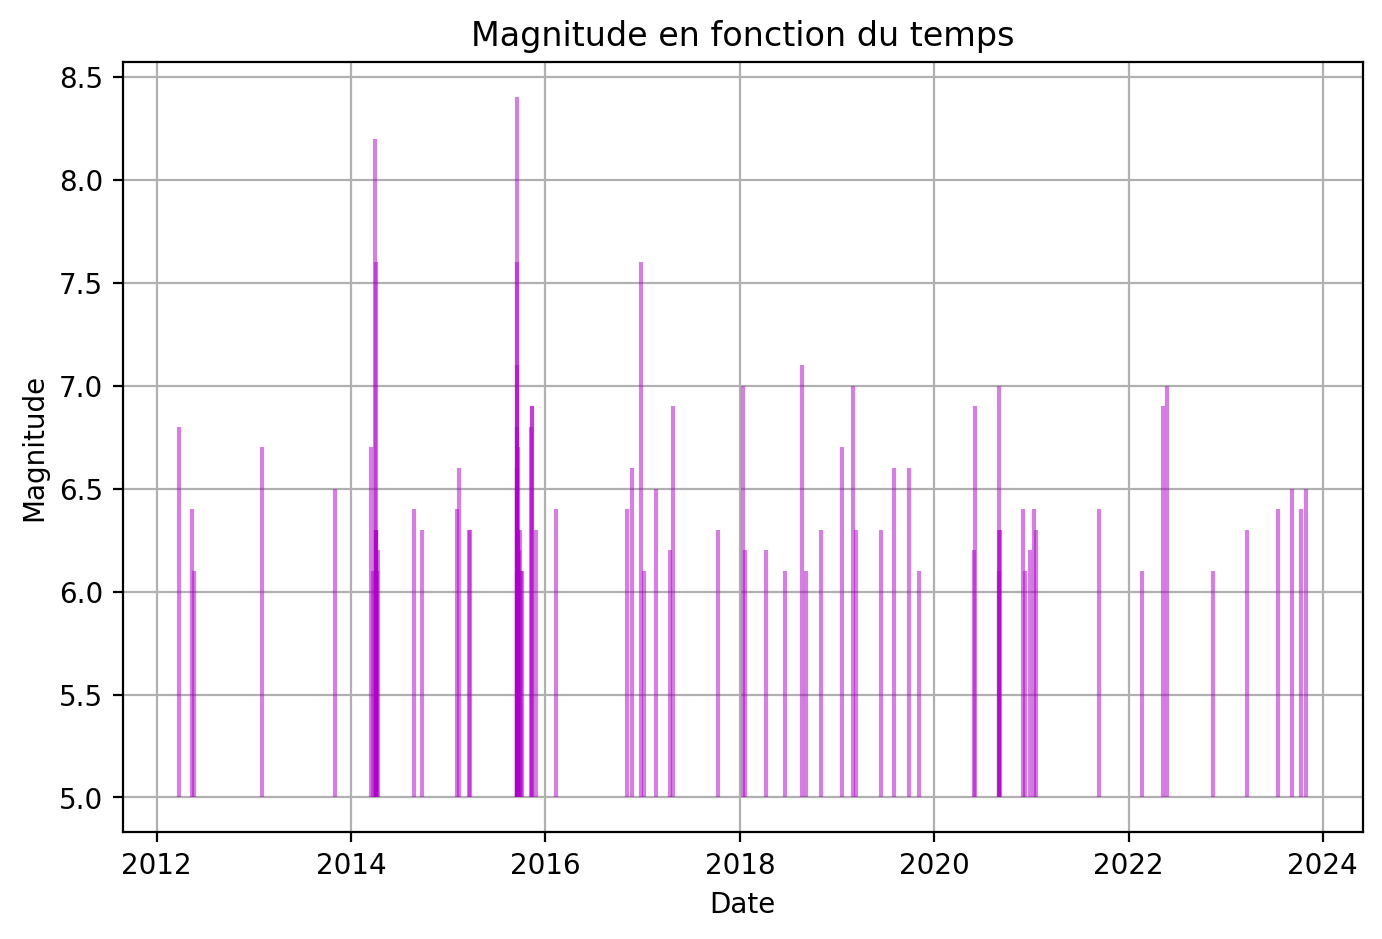

In [ ]:
df = df[df['Magnitude']>6]

plt.figure(figsize=(8, 5), dpi=200)
plt.vlines(df['Date'], ymin=5, ymax=df['Magnitude'], color='#AE00C8', alpha=0.5)
plt.title('Magnitude en fonction du temps')
plt.xlabel('Date')
plt.ylabel('Magnitude')
plt.grid(True)
plt.show()

In [ ]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d %H:%M:%S')

reference_time = df['Date'].min()
print(reference_time)

df['Elapsed_Time'] = (df['Date'] - reference_time).dt.total_seconds() / (24 * 3600)

data = df['Elapsed_Time'].values

2012-03-25 22:37:06


In [ ]:
uv = UVHP()
uv.fit(data)
print(uv.get_params())

(0.012864242898203862, 0.36309458444032705, 0.3316952459035796)


In [ ]:
def simulate_hawkes(params, simulation_time):
    mu, alpha, theta = params['mu'], params['alpha'], params['theta']
    event_times = []
    t = 0
    while t < simulation_time:
        intensity = mu
        for event_time in event_times:
            if event_time < t:
              intensity += alpha * np.exp(-theta * (t - event_time))
        t += np.random.exponential(scale=1 / intensity)
        if t < simulation_time:
            event_times.append(t)
    return event_times

params = {'mu': 0.012864242898203862,
          'alpha': 0.36309458444032705,
          'theta': 0.3316952459035796}

simulation_time = 4000
event_times = simulate_hawkes(params, simulation_time)

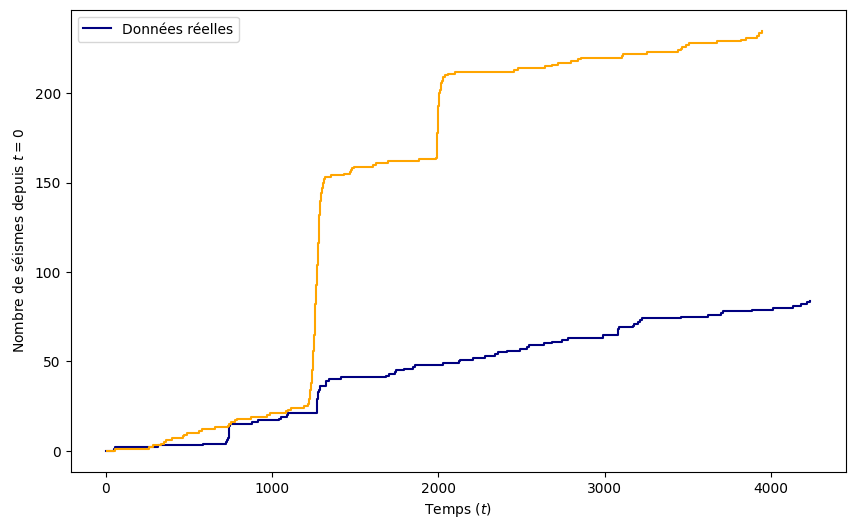

In [ ]:
plt.figure(figsize=(10, 6))
plt.step(data, np.arange(len(data)), color='navy', label='Données réelles', where='post')
plt.step(event_times, np.arange(len(event_times)), color='orange', where='post')

plt.xlabel(r'Temps $(t)$')
plt.ylabel(r"Nombre de séismes depuis $t=0$")
plt.legend()
plt.show()

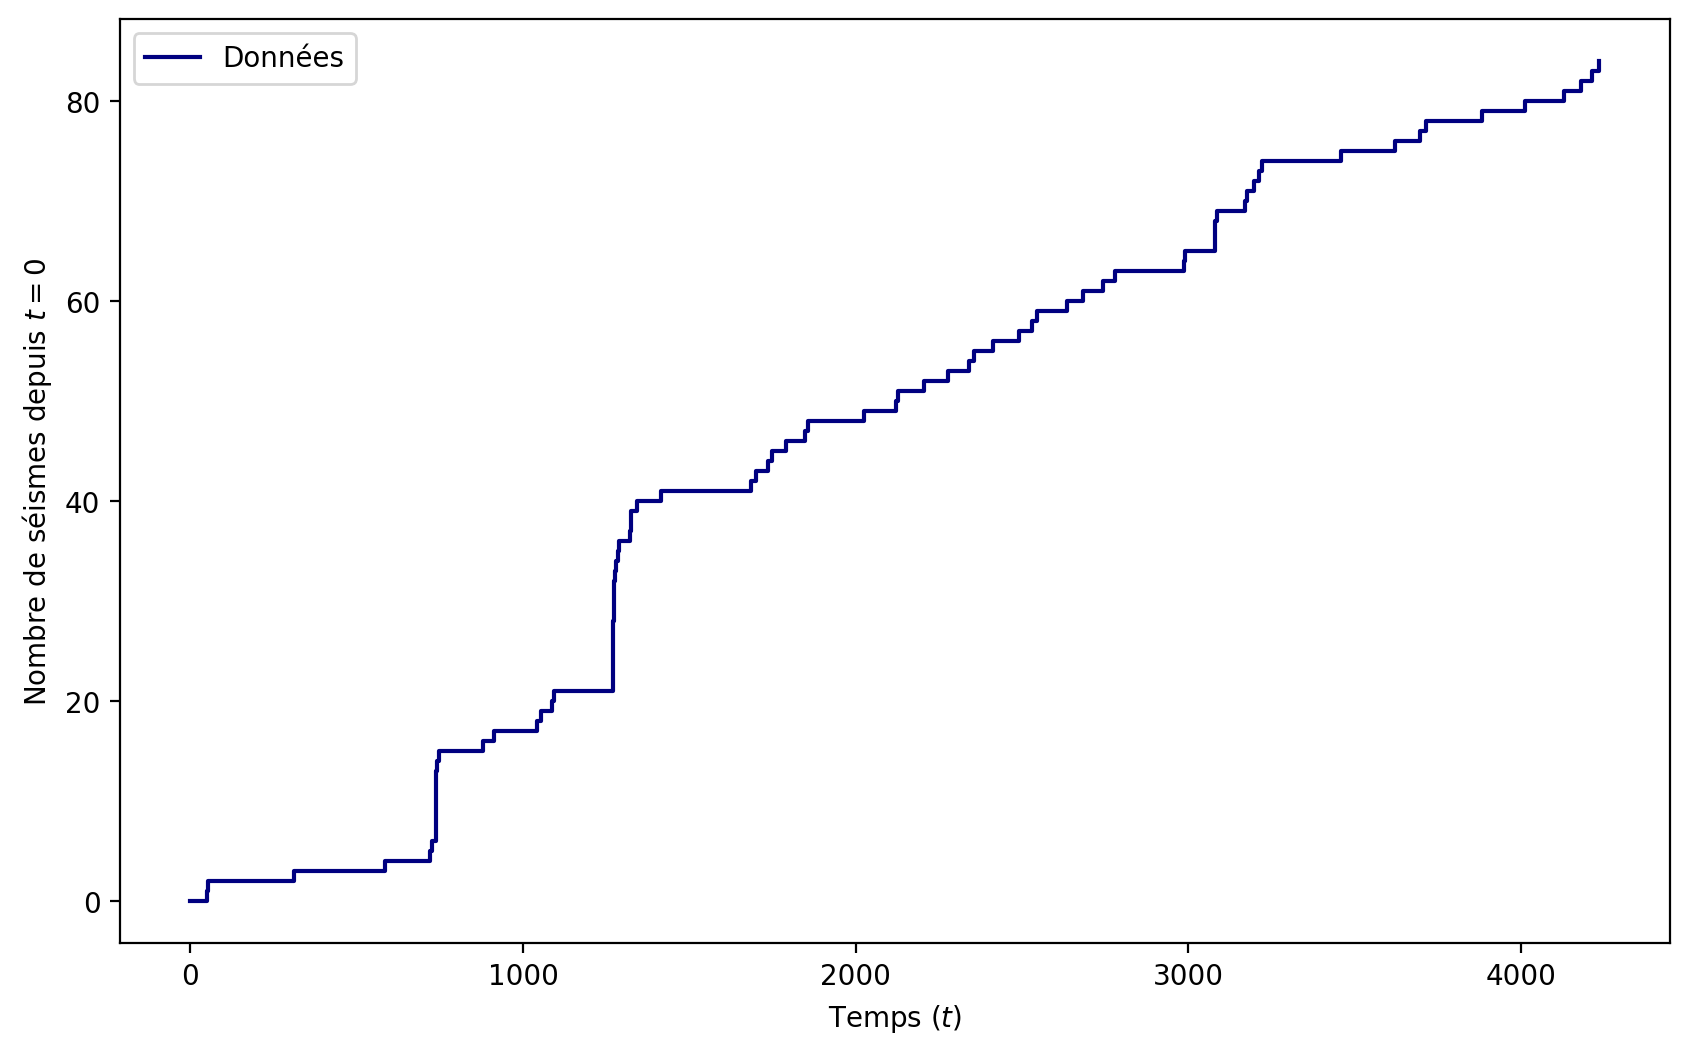

In [ ]:
plt.figure(figsize=(10, 6),dpi=200)
plt.step(data, np.arange(len(data)), color='navy', label='Données', where='post')

plt.xlabel(r'Temps $(t)$')
plt.ylabel(r"Nombre de séismes depuis $t=0$")
plt.legend()
plt.show()

Interpreting the parameters, we conclude that earthquakes occur exogenously once every ~78 days (here, we call any registered seismic activity an “earthquake”) in Chile, so a bit more than two months. Each main shock results in 0.36 aftershocks on average, and aftershocks occur with 3 days delay on average.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_hawkes(params, num_trajectories, simulation_time, max_events_per_trajectory=200):
    mu, alpha, theta = params['mu'], params['alpha'], params['theta']
    all_event_times = []
    for _ in range(num_trajectories):
        event_times = []
        t = 0
        events_generated = 0
        while t < simulation_time and events_generated < max_events_per_trajectory:
            intensity = mu
            for event_time in event_times:
                if event_time < t:
                    intensity += alpha * np.exp(-theta * (t - event_time))
            t += np.random.exponential(scale=1 / intensity)
            if t < simulation_time:
                event_times.append(t)
                events_generated += 1
        if events_generated < max_events_per_trajectory:
            all_event_times.append(event_times)
    return all_event_times

params = {'mu': 0.012864242898203862,
          'alpha': 0.36309458444032705,
          'theta': 0.3316952459035796}

In [ ]:
num_trajectories = 5
simulation_time = 4000

all_event_times = simulate_hawkes(params, num_trajectories, simulation_time)

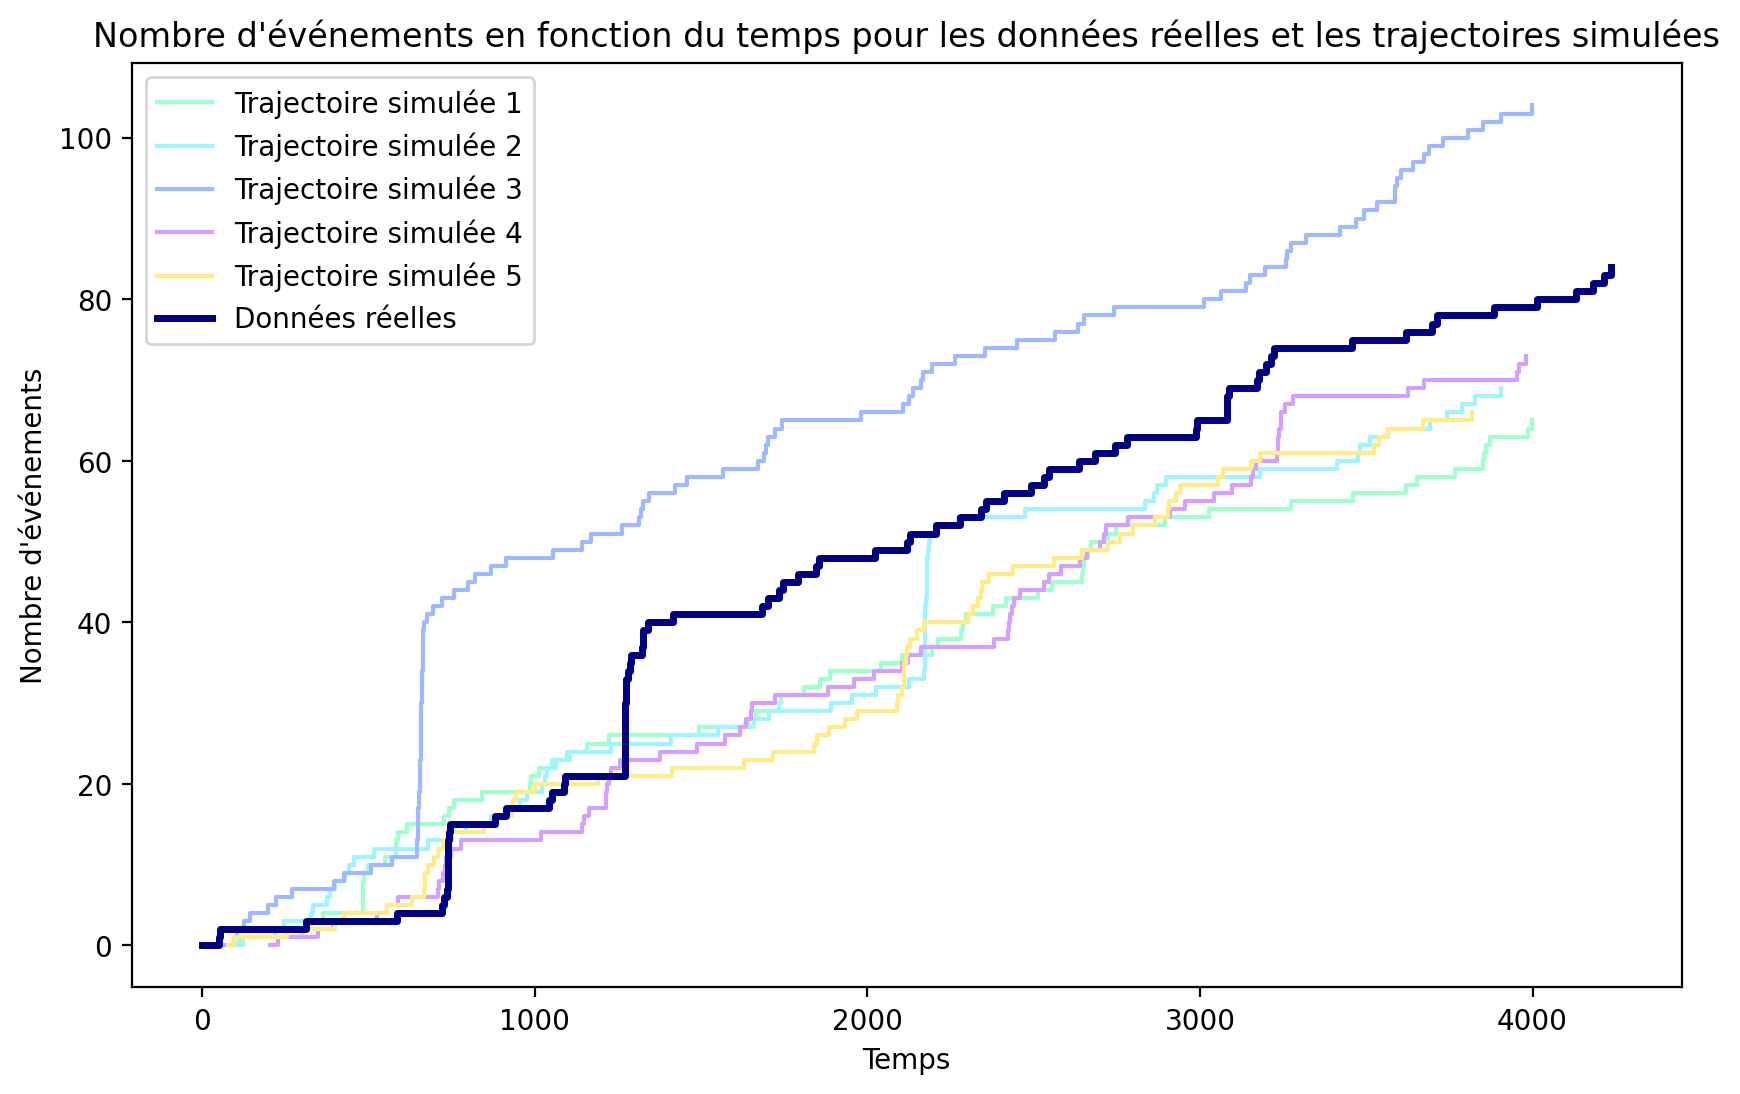

In [ ]:
plt.figure(figsize=(10, 6),dpi=200)
colors = ['#A0FFCE', "#A0F4FF", "#A0B8FF", "#D4A0FF", "#FFEC88"]
for i, event_times in enumerate(all_event_times):
    plt.step(event_times, np.arange(len(event_times)), label=f'Trajectoire simulée {i+1}', where='post', color=colors[i])
plt.step(data, np.arange(len(data)), color='navy', label='Données réelles', lw=2.5, where='post')
plt.xlabel('Temps')
plt.ylabel("Nombre d'événements")
plt.title("Nombre d'événements en fonction du temps pour les données réelles et les trajectoires simulées")
plt.legend()
plt.show()

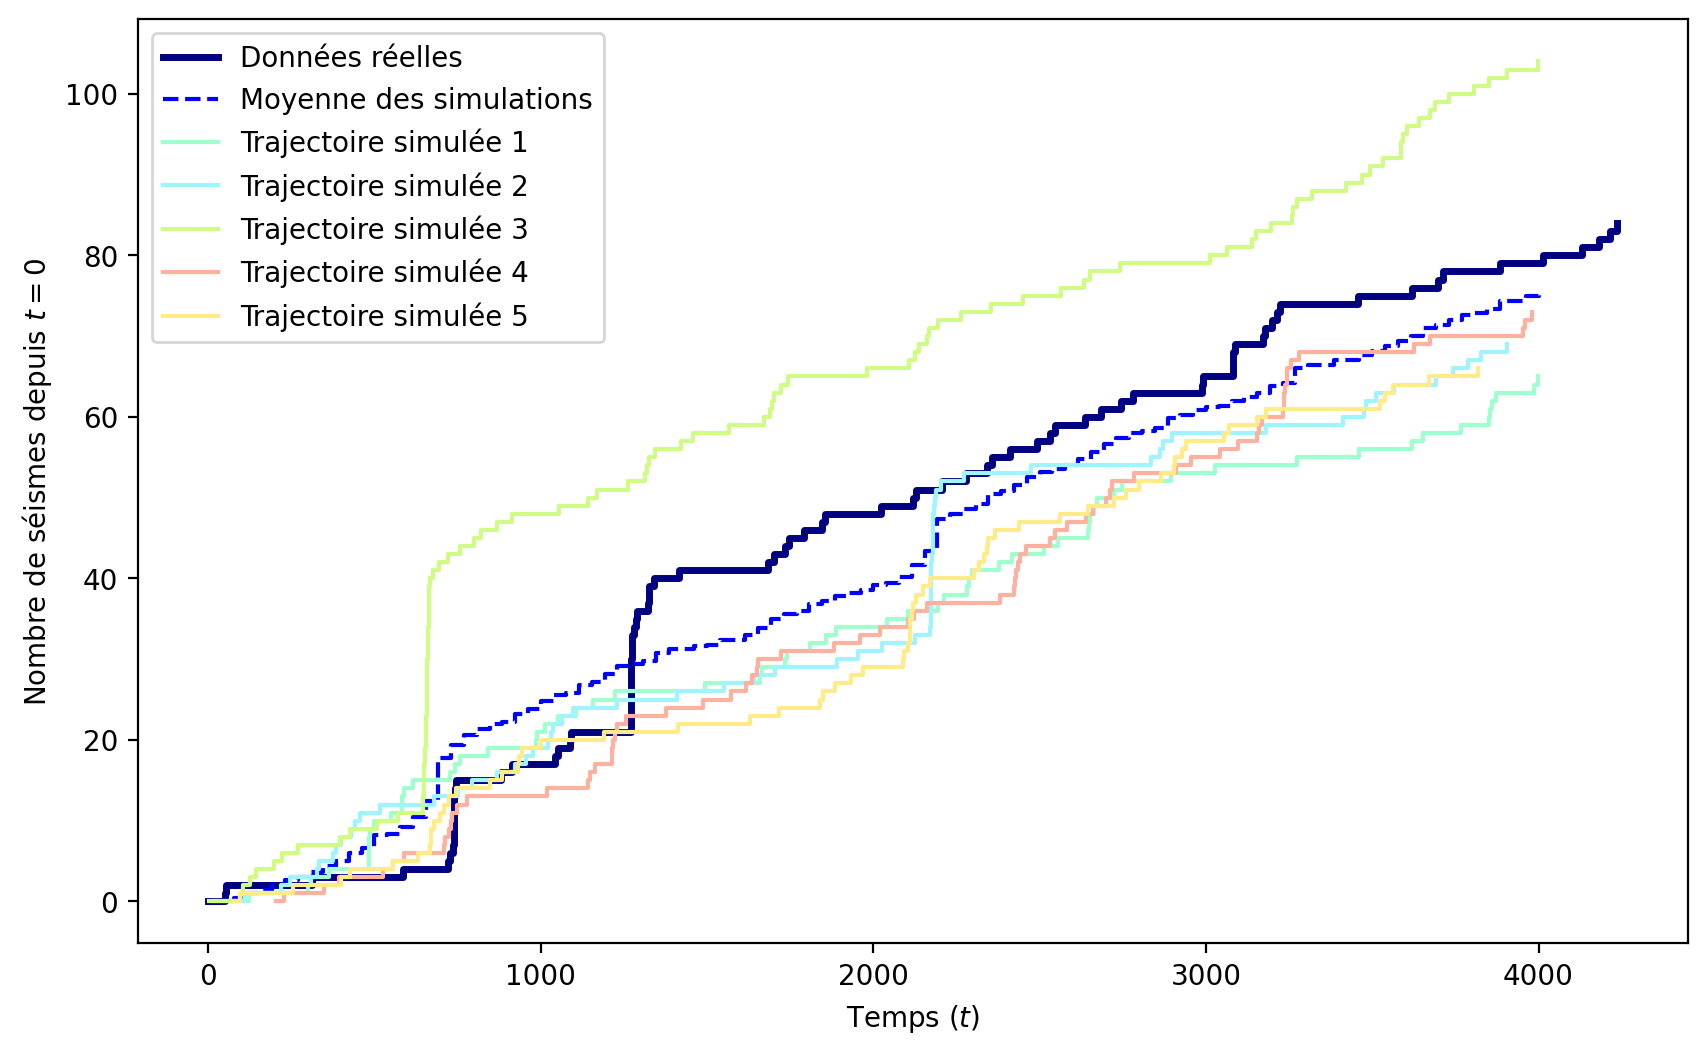

In [ ]:
max_length = max(len(event_times) for event_times in all_event_times)
time_grid = np.linspace(0, simulation_time, max_length)

interpolated_event_counts = np.zeros((len(all_event_times), max_length))
for i, event_times in enumerate(all_event_times):
    interpolator = interp1d(event_times, np.arange(len(event_times)), kind='nearest', bounds_error=False, fill_value=(0, len(event_times)-1))
    interpolated_event_counts[i] = interpolator(time_grid)

average_event_counts = np.mean(interpolated_event_counts, axis=0)

plt.figure(figsize=(10, 6), dpi=200)
colors = ['#A0FFCE', "#A0F4FF", "#D0FB85", "#FFB19F", "#FFEC88"]
plt.step(data, np.arange(len(data)), color='navy', label='Données réelles', lw=2.5, where='post')

plt.step(time_grid, average_event_counts, label='Moyenne des simulations', linestyle='--', color='blue', where='post')

for i, event_times in enumerate(all_event_times):
    plt.step(event_times, np.arange(len(event_times)), label=f'Trajectoire simulée {i+1}', where='post', color=colors[i])
plt.xlabel(r'Temps ($t$)')
plt.ylabel(r"Nombre de séismes depuis $t=0$")
plt.legend()
plt.show()



In [ ]:
num_trajectories = 100
simulation_time = 4000

all_event_times_big = simulate_hawkes(params, num_trajectories, simulation_time)

In [ ]:
max_length = max(len(event_times) for event_times in all_event_times_big)
time_grid = np.linspace(0, simulation_time, max_length)

interpolated_event_counts = np.zeros((len(all_event_times_big), max_length))
for i, event_times in enumerate(all_event_times_big):
    interpolator = interp1d(event_times, np.arange(len(event_times)), kind='nearest', bounds_error=False, fill_value=(0, len(event_times)-1))
    interpolated_event_counts[i] = interpolator(time_grid)

average_event_counts = np.mean(interpolated_event_counts, axis=0)

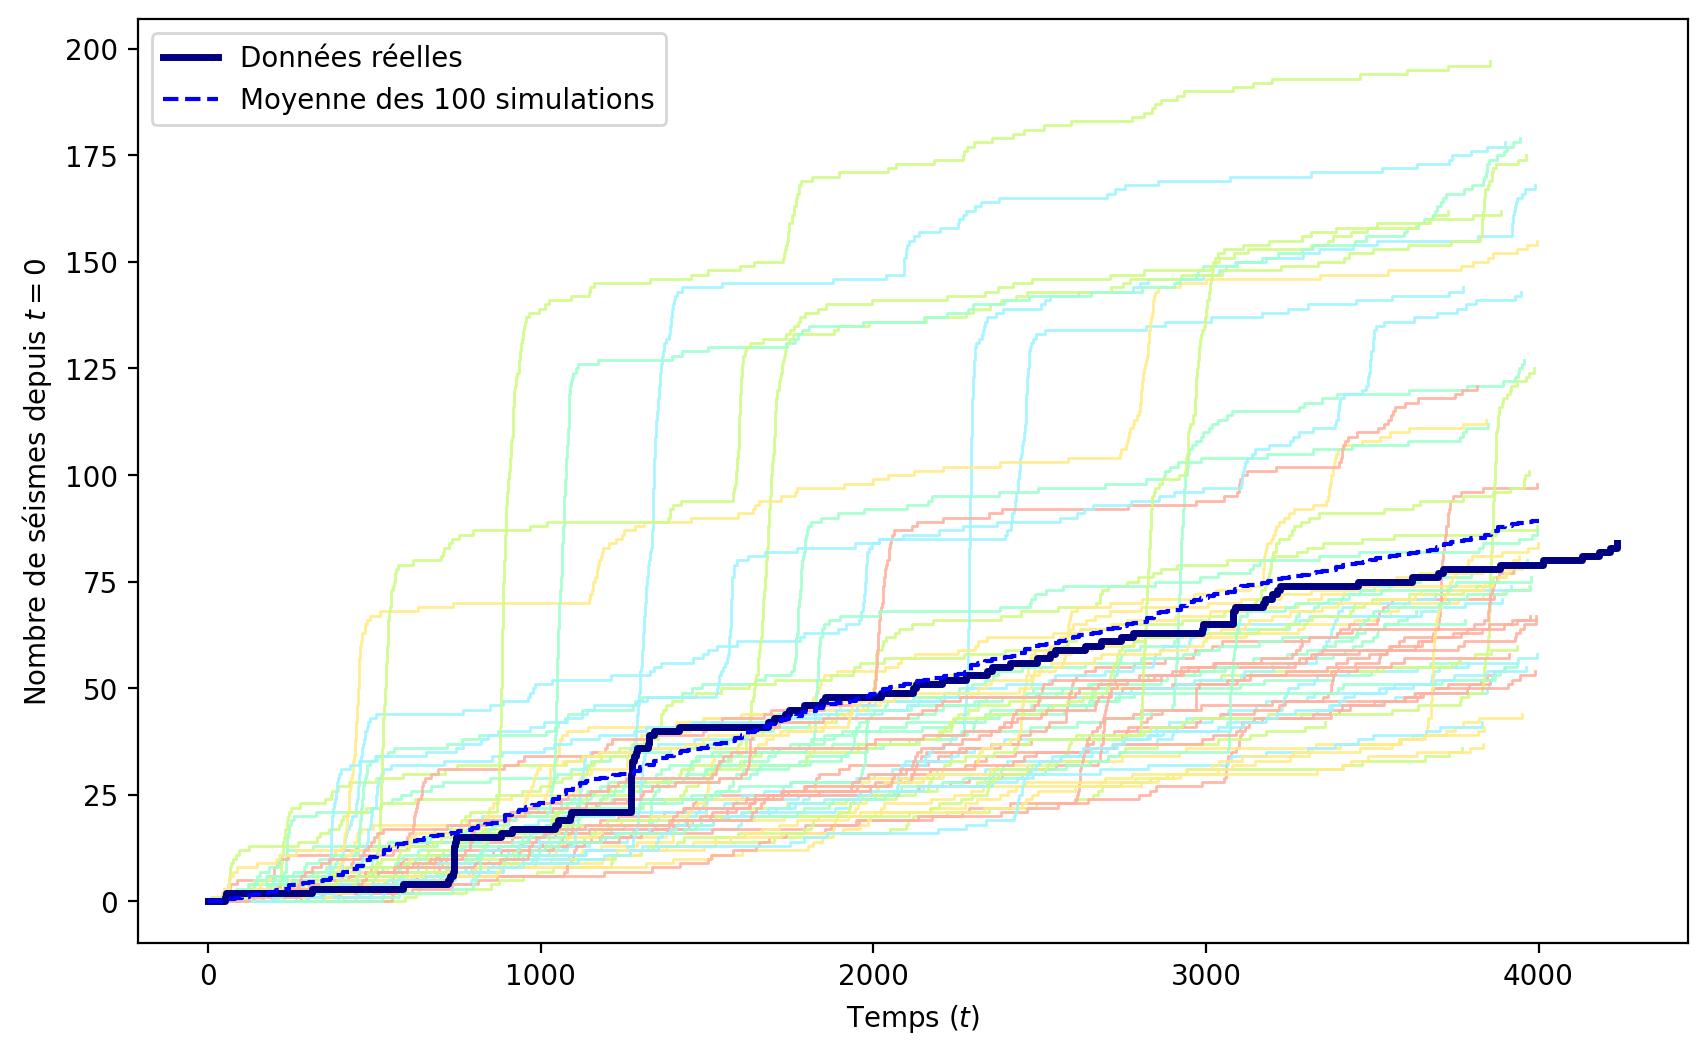

In [ ]:
plt.figure(figsize=(10, 6), dpi=200)
colors = ['#A0FFCE', "#A0F4FF", "#D0FB85", "#FFB19F", "#FFEC88"]

for i, event_times in enumerate(all_event_times_big):
    plt.step(event_times, np.arange(len(event_times)), where='post', lw=1, alpha=0.9, color=colors[i%5])

plt.step(data, np.arange(len(data)), color='navy', label='Données réelles', lw=2.5, where='post')
plt.step(time_grid, average_event_counts, label=f'Moyenne des {num_trajectories} simulations', linestyle='--', color='blue', where='post')

plt.xlabel(r'Temps ($t$)')
plt.ylabel(r"Nombre de séismes depuis $t=0$")
plt.legend()
plt.show()

In [ ]:
light_colors = [
    "#FFD1DC", "#FFB6C1", "#FFC0CB", "#FF69B4", "#FF8C00",
    "#FFA07A", "#FF6347", "#FFD700", "#FFFF00", "#ADFF2F",
    "#7FFF00", "#32CD32", "#00FF00", "#90EE90", "#98FB98",
    "#20B2AA", "#00FFFF", "#AFEEEE", "#00CED1", "#00BFFF",
    "#ADD8E6", "#87CEEB", "#4682B4", "#6A5ACD", "#7B68EE",
    "#8A2BE2", "#9400D3", "#BA55D3", "#DA70D6", "#FF69B4",
    "#FF1493", "#FF00FF", "#FF00FF", "#8A2BE2", "#9370DB",
    "#D8BFD8", "#DDA0DD", "#EE82EE", "#FFC0CB", "#FFB6C1",
    "#FF69B4", "#FF1493", "#DB7093", "#C71585", "#FF6347",
    "#FF4500", "#FF8C00", "#FFA500", "#FFD700", "#FFFF00",
    "#ADFF2F", "#7FFF00", "#32CD32", "#00FF00", "#90EE90",
    "#98FB98", "#20B2AA", "#00FFFF", "#AFEEEE", "#00CED1",
    "#00BFFF", "#ADD8E6", "#87CEEB", "#4682B4", "#6A5ACD",
    "#7B68EE", "#8A2BE2", "#9400D3", "#BA55D3", "#DA70D6",
    "#FF69B4", "#FF1493", "#FF00FF", "#FF00FF", "#8A2BE2",
    "#9370DB", "#D8BFD8", "#DDA0DD", "#EE82EE", "#FFC0CB",
    "#FFB6C1", "#FF69B4", "#FF1493", "#DB7093", "#C71585",
    "#FF6347", "#FF4500", "#FF8C00", "#FFA500", "#FFD700",
    "#FFFF00", "#ADFF2F", "#7FFF00", "#32CD32", "#00FF00",
    "#90EE90", "#98FB98", "#20B2AA", "#00FFFF", "#AFEEEE",
    "#00CED1", "#00BFFF", "#ADD8E6", "#87CEEB", "#4682B4",
    "#6A5ACD", "#7B68EE", "#8A2BE2", "#9400D3", "#BA55D3",
    "#DA70D6"
]

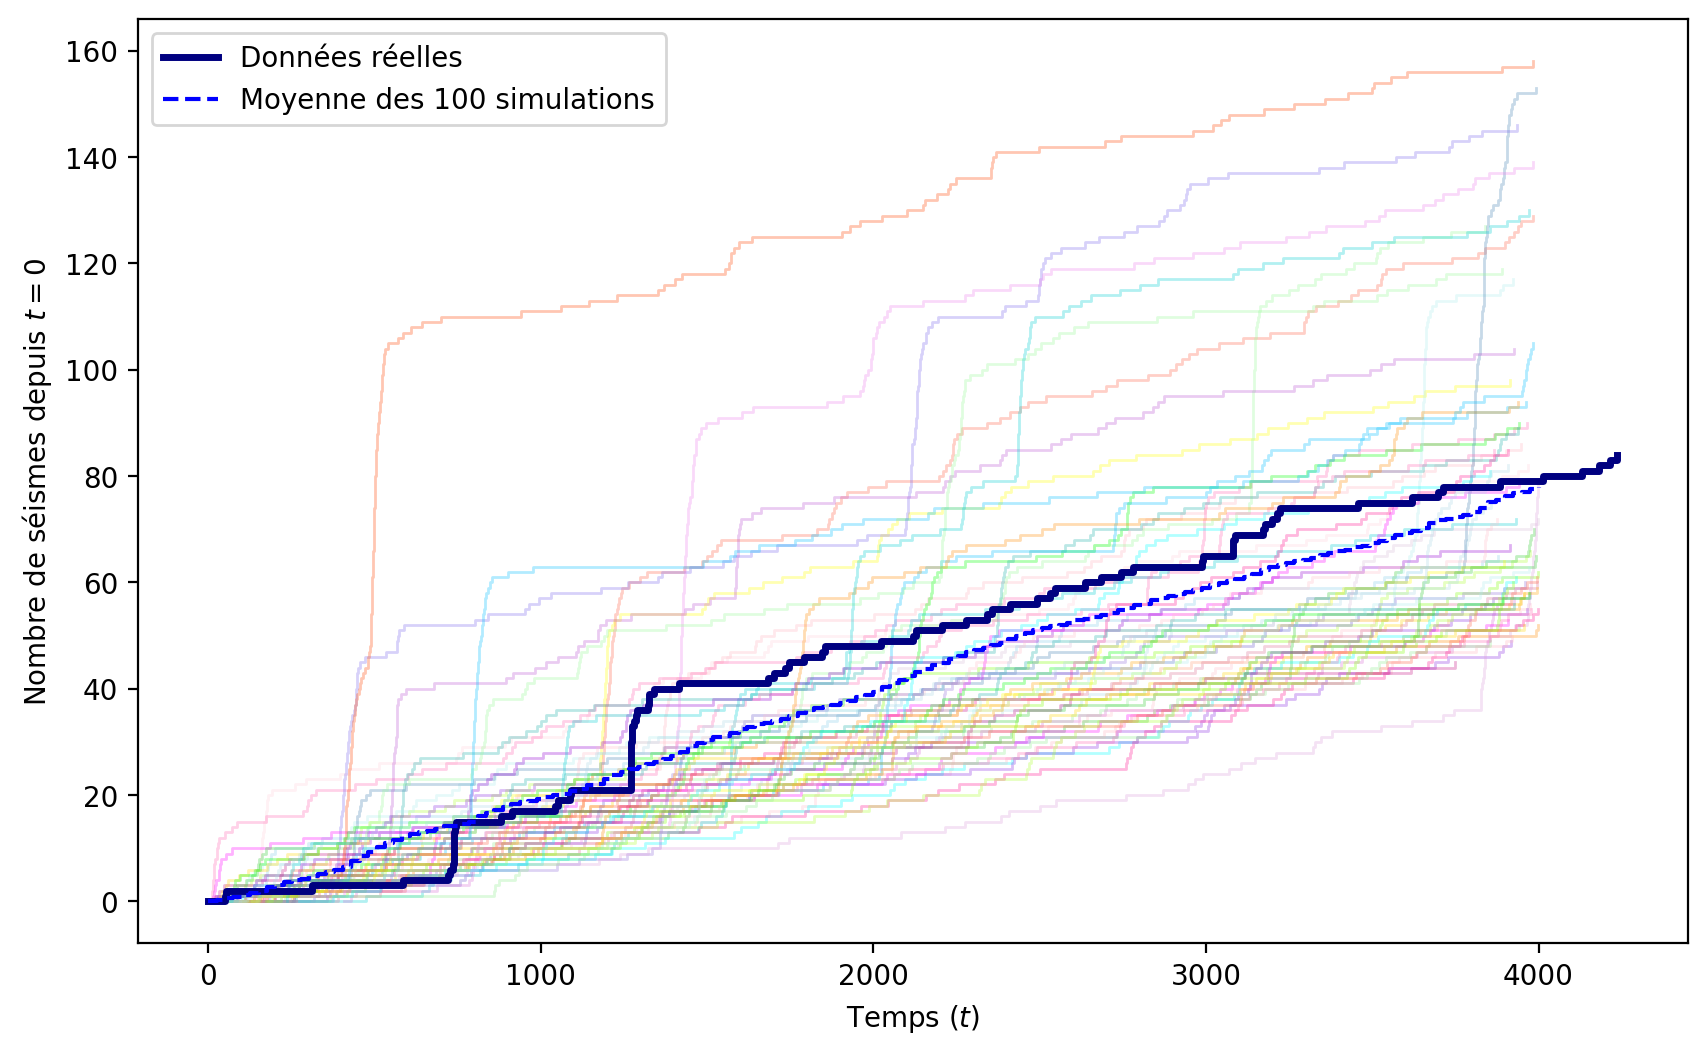

In [ ]:
plt.figure(figsize=(10, 6), dpi=200)
colors = ['#A0FFCE', "#A0F4FF", "#D0FB85", "#FFB19F", "#FFEC88"]

for i, event_times in enumerate(all_event_times_big):
    plt.step(event_times, np.arange(len(event_times)), where='post', lw=1, alpha=0.3, color=light_colors[i])

plt.step(data, np.arange(len(data)), color='navy', label='Données réelles', lw=2.5, where='post')
plt.step(time_grid, average_event_counts, label=f'Moyenne des {num_trajectories} simulations', linestyle='--', color='blue', where='post')

plt.xlabel(r'Temps ($t$)')
plt.ylabel(r"Nombre de séismes depuis $t=0$")
plt.legend()
plt.show()